**PROBLEM STATEMENT - TO PREDICT/IDENTIFY THE NAME OF THE BREED BASED ON THE IMAGE OF THE DOG.**

**OVERVIEW:**
1.   Image recognition and classification have successfully applied in various domains, such as face recognition and scene understanding of autonomous driving.
2.   At present, human face identification is successfully used for authentication and security purposes in many applications.
3.   Therefore, there are attempts to extend studies from human to animal recognition. In particular, dogs are one of the most common animals.
4.   Since there are more than 180 dog breeds, dog breed recognition can be an essential task in order to provide proper training and health treatment.
5.   Previously, dog breed recognition is done by human experts. However, some dog breeds might be challenging to evaluate due
to the lack of experts and the difficulty of breeds' patterns themselves. It also takes time for each evaluation.
6.   The main objective of this case study is to create a classifier capable of determining a dog’s breed from an image.
7.   In this competition, a strictly canine subset of ImageNet has been provided in order to practice fine-grained image categorization.
8.   We have been provided with training set and a test set of images of dogs and there are total of 20581 files.
9.   Each image has a filename that is its unique id.
10.  The data set contains 120 breeds of dogs.
11.  For each image in the test data, we must predict a probability for each of the different breeds as part of the case study.
12.  Multi class log loss between the predicted probability and the observed target has been used as the metric.


In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1673850660&Signature=FcLZMSJVJxjtE2tsl49iuWYSLXLVz5r%2FNS4wvu6aA85rXfzDlUY5ljON9KulrBZqoF43HZqdJRTy%2FfqKuWfgLOanR7G1Axw28JC0GM0qjd%2FN96nDckmlPqJYWSRSF%2B7Ca6hSkQkl1YA1%2BAJteVj37UY9U%2FB5tIcwxcYXUvclTa8lgvsUuTT8oPuvy1Vbo4kENJZ5BI%2BEgX23X3O77jDc5WKnn5WUavxpyZ513BBfehOVKZfuAdf30z722ETvmExGHWGbRclESVJaoH1piGBOv5HuIIyDEyWQ%2BYxpNT3Zqbf8aNqFYEkqrjvcNF%2BUDCItRBbC2sp%2BT%2Frc9t79YHoTKA%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip" -c -O 'dog-breed-identification.zip'

In [3]:
import zipfile
extract = zipfile.ZipFile('/content/dog-breed-identification.zip')
extract.extractall()

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pickle
import os

In [5]:
labels = pd.read_csv('labels.csv')
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [10]:
files_path = []
for root, dirs, files in os.walk("train", topdown=False):
   for name in sorted(files):
      files_path.append(os.path.join(root, name))

In [16]:
files = pd.DataFrame(list(zip(files_path,labels.breed.to_list())),columns=['path','label'])
files.head()

path             label
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  train/001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  train/001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  train/00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  train/0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

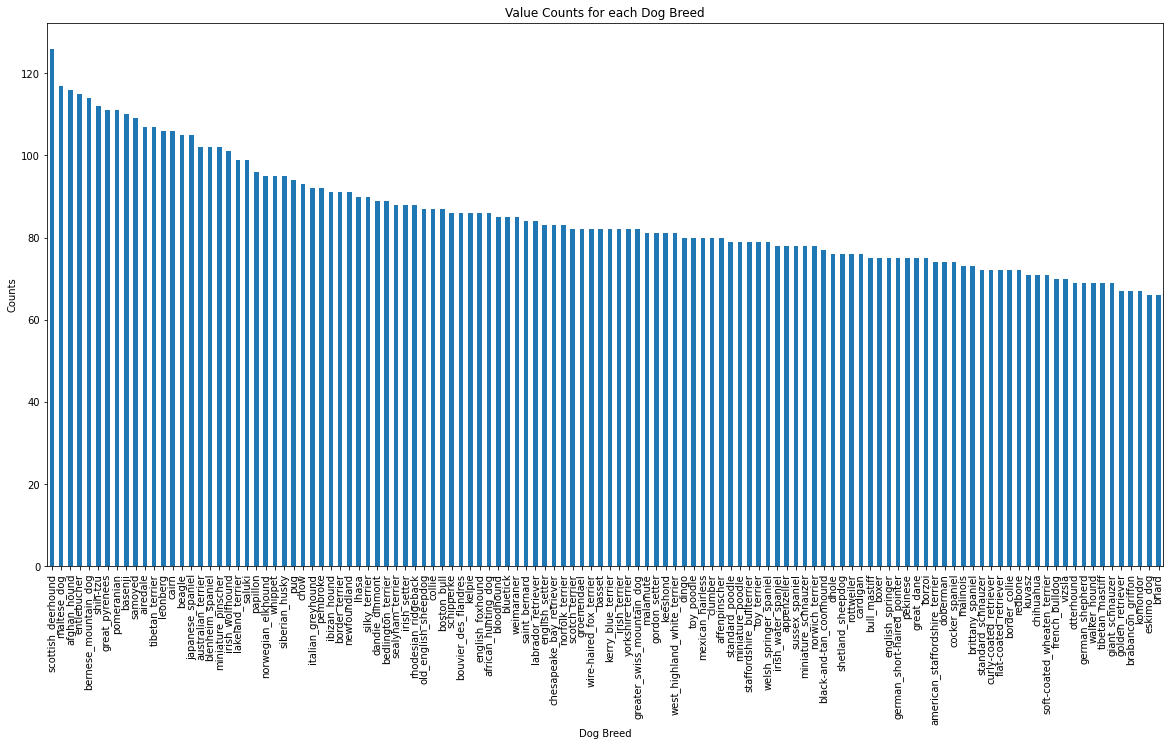

In [17]:
#Plotting the counts of each Dog Breed  using bar plot in descending order
plt.figure(figsize=(20,10))
files['label'].value_counts().plot(kind='bar')
plt.xlabel('Dog Breed')
plt.ylabel('Counts')
plt.title('Value Counts for each Dog Breed')
plt.show()

**OBSERVATIONS:**

1.   Counts of each breed looks good and the dataset is nearly balanced.
2.   The Scottish Deerhound Dog Breed is maximum in number.
3.   The Eskimo Dog and Briard Dog Breeds are minimum in number.


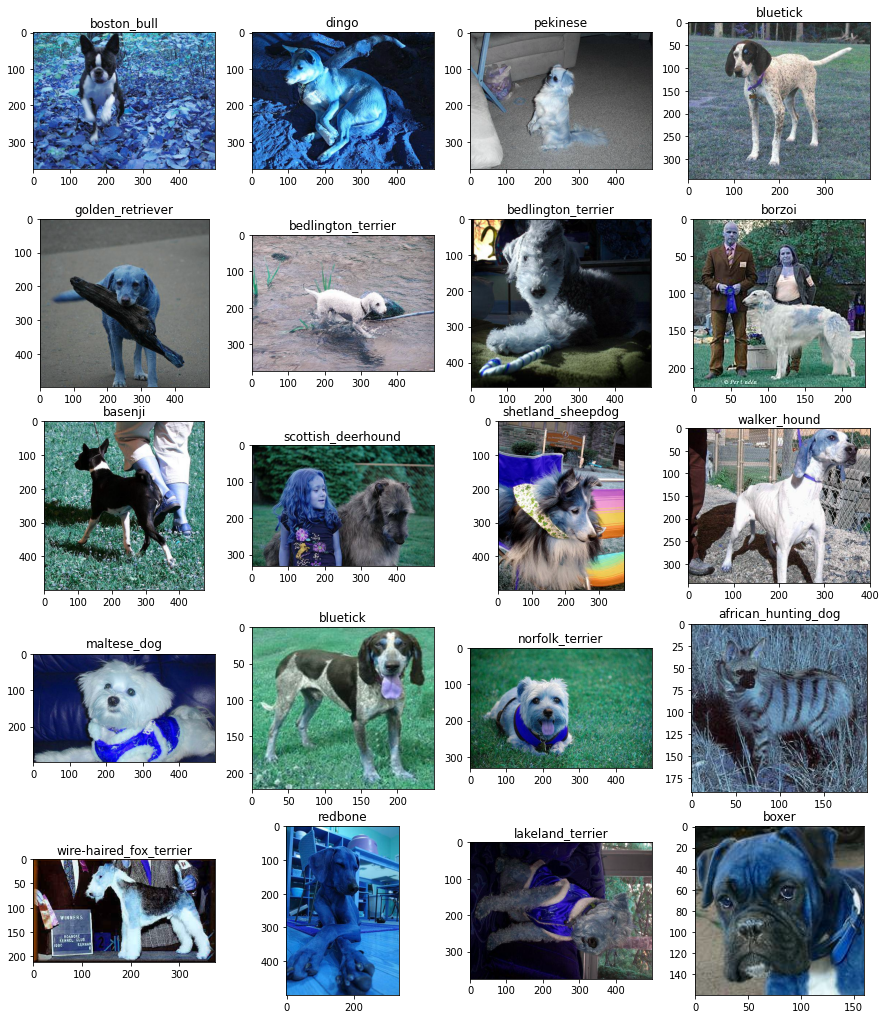

In [18]:
#Plotting few images from the train data provided.
import cv2
plt.figure(figsize=(15,18))
for i in range(20):
  plt.subplot(5,4,i+1)
  image = cv2.imread(files['path'][i])
  plt.imshow(image)
  plt.title(files['label'][i])
plt.show()

**TRAIN TEST SPLIT:**

In [19]:
from sklearn.model_selection import train_test_split
Train, validation = train_test_split(files,test_size=0.33, stratify = files['label'],random_state=42)

**ENCODING TARGET LABELS:**

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'].to_list())
Train_image_labels       = le.transform(Train['label'].to_list())
validation_image_labels  = le.transform(validation['label'].to_list())

In [21]:
with open('/content/drive/MyDrive/dog_breed/encoder','wb') as file:
  pickle.dump(le,file)

In [22]:
with open('/content/drive/MyDrive/dog_breed/labels','wb') as file:
  pickle.dump(list(le.classes_),file)

In [23]:
Train_image_paths        = Train['path'].tolist()
validation_image_paths   = validation['path'].tolist()

In [24]:
def tfdata_generator(images, labels, is_training, batch_size=16):
  def parse_function(filename,labels):
    #decoding JPG file
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image/255
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [400,400])
    y = tf.one_hot(tf.cast(labels, tf.uint8), 120)
    return image,y

  def augment(image,labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=6, dtype=tf.int32))
    image = tf.image.random_hue(image, 0.5)
    image = tf.image.random_saturation(image, 0.5, 2.5)
    image = tf.image.random_brightness(image, 0.5)
    image = tf.image.random_contrast(image, 0.1, 2)
    
    return image,labels
  
  dataset = tf.data.Dataset.from_tensor_slices((images,labels))
  if is_training:
    dataset = dataset.shuffle(18000) # depends on sample size
  # Transform and batch data at the same time
  dataset = dataset.map(parse_function)
  dataset = dataset.batch(batch_size, drop_remainder=True if is_training else False)
  
  if is_training:
    if np.random.uniform(0,1)>0.6:
      dataset = dataset.map(augment,num_parallel_calls=4)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [25]:
train_generator       = tfdata_generator(Train_image_paths, Train_image_labels, is_training=True)
validation_generator  = tfdata_generator(validation_image_paths, validation_image_labels, is_training=False)

In [26]:
steps_per_epoch  = np.ceil(len(Train_image_paths)/16)
validation_steps = np.ceil(len(validation_image_paths)/16)

In [27]:
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,GlobalAveragePooling2D,Concatenate,BatchNormalization
from keras.models import Model
from keras.utils import plot_model
import os
import random as rn
os.environ['PYTHONHASHSEED'] = '0'
keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

In [28]:
input_shape = (400,400,3)
input_layer = Input(shape = (400,400,3))
#first model
base_inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_resnet    = ResNet152(weights = 'imagenet', include_top = False, input_shape = input_shape)
for layer in base_inception.layers:
    layer.trainable =  False
for layer in base_resnet.layers:
    layer.trainable = False
model_inception  = base_inception(input_layer)
model_inception  = GlobalAveragePooling2D()(model_inception)
output_inception = Flatten()(model_inception)
model_resnet     = base_resnet(input_layer)
model_resnet     = GlobalAveragePooling2D()(model_resnet)
output_resnet    = Flatten()(model_resnet)
merged = Concatenate()([output_inception, output_resnet])
x = BatchNormalization()(merged)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(120, activation = 'softmax')(x)
Inception_resnet_stacked = Model(inputs = input_layer, outputs = x)

234698864/234698864 [==============================] - 7s 0us/step


In [29]:
Inception_resnet_stacked.compile(optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
                                 loss='categorical_crossentropy',metrics=['categorical_accuracy'])
Inception_resnet_stacked.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 11, 11, 2048  21802784    ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 resnet152 (Functional)         (None, 13, 13, 2048  58370944    ['input_1[0][0]']                
                                )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
mc        = ModelCheckpoint('/content/drive/MyDrive/dog_breed/Inception_resnet_stacked_weights.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2,verbose=0) 

In [ ]:
Inception_resnet_stacked.fit(train_generator,steps_per_epoch=steps_per_epoch,
                             validation_data  = validation_generator,epochs=10,
                             validation_steps = validation_steps,
                             callbacks        = [mc,reduce_lr])

Epoch 1/10
428/428 [==============================] - ETA: 0s - loss: 2.3110 - categorical_accuracy: 0.5076
Epoch 1: val_loss improved from inf to 0.62099, saving model to /content/drive/MyDrive/dog_breed/Inception_resnet_stacked_weights.h5
428/428 [==============================] - 310s 671ms/step - loss: 2.3110 - categorical_accuracy: 0.5076 - val_loss: 0.6210 - val_categorical_accuracy: 0.8889 - lr: 0.0010
Epoch 2/10
428/428 [==============================] - ETA: 0s - loss: 0.6635 - categorical_accuracy: 0.8331
Epoch 2: val_loss improved from 0.62099 to 0.31263, saving model to /content/drive/MyDrive/dog_breed/Inception_resnet_stacked_weights.h5
428/428 [==============================] - 290s 678ms/step - loss: 0.6635 - categorical_accuracy: 0.8331 - val_loss: 0.3126 - val_categorical_accuracy: 0.9034 - lr: 0.0010
Epoch 3/10
428/428 [==============================] - ETA: 0s - loss: 0.4468 - categorical_accuracy: 0.8795
Epoch 3: val_loss improved from 0.31263 to 0.28231, saving mod

***Plotting Loss:***

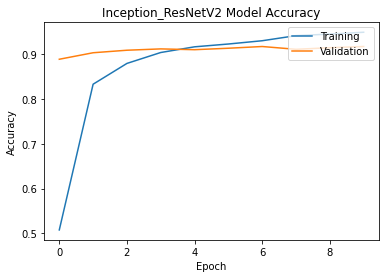

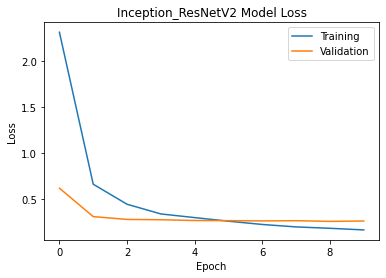

In [ ]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Inception_ResNetV2 Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Inception_ResNetV2 Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

plot_history(Inception_resnet_stacked.history)

**ACTUAL VS PREDICTED LABEL COMPARISON FOR SAMPLE VALIDATION DATA:**

In [ ]:
from keras.models import load_model
Stacked_model_1 = load_model('/content/drive/MyDrive/dog_breed/Inception_resnet_stacked_weights.h5')

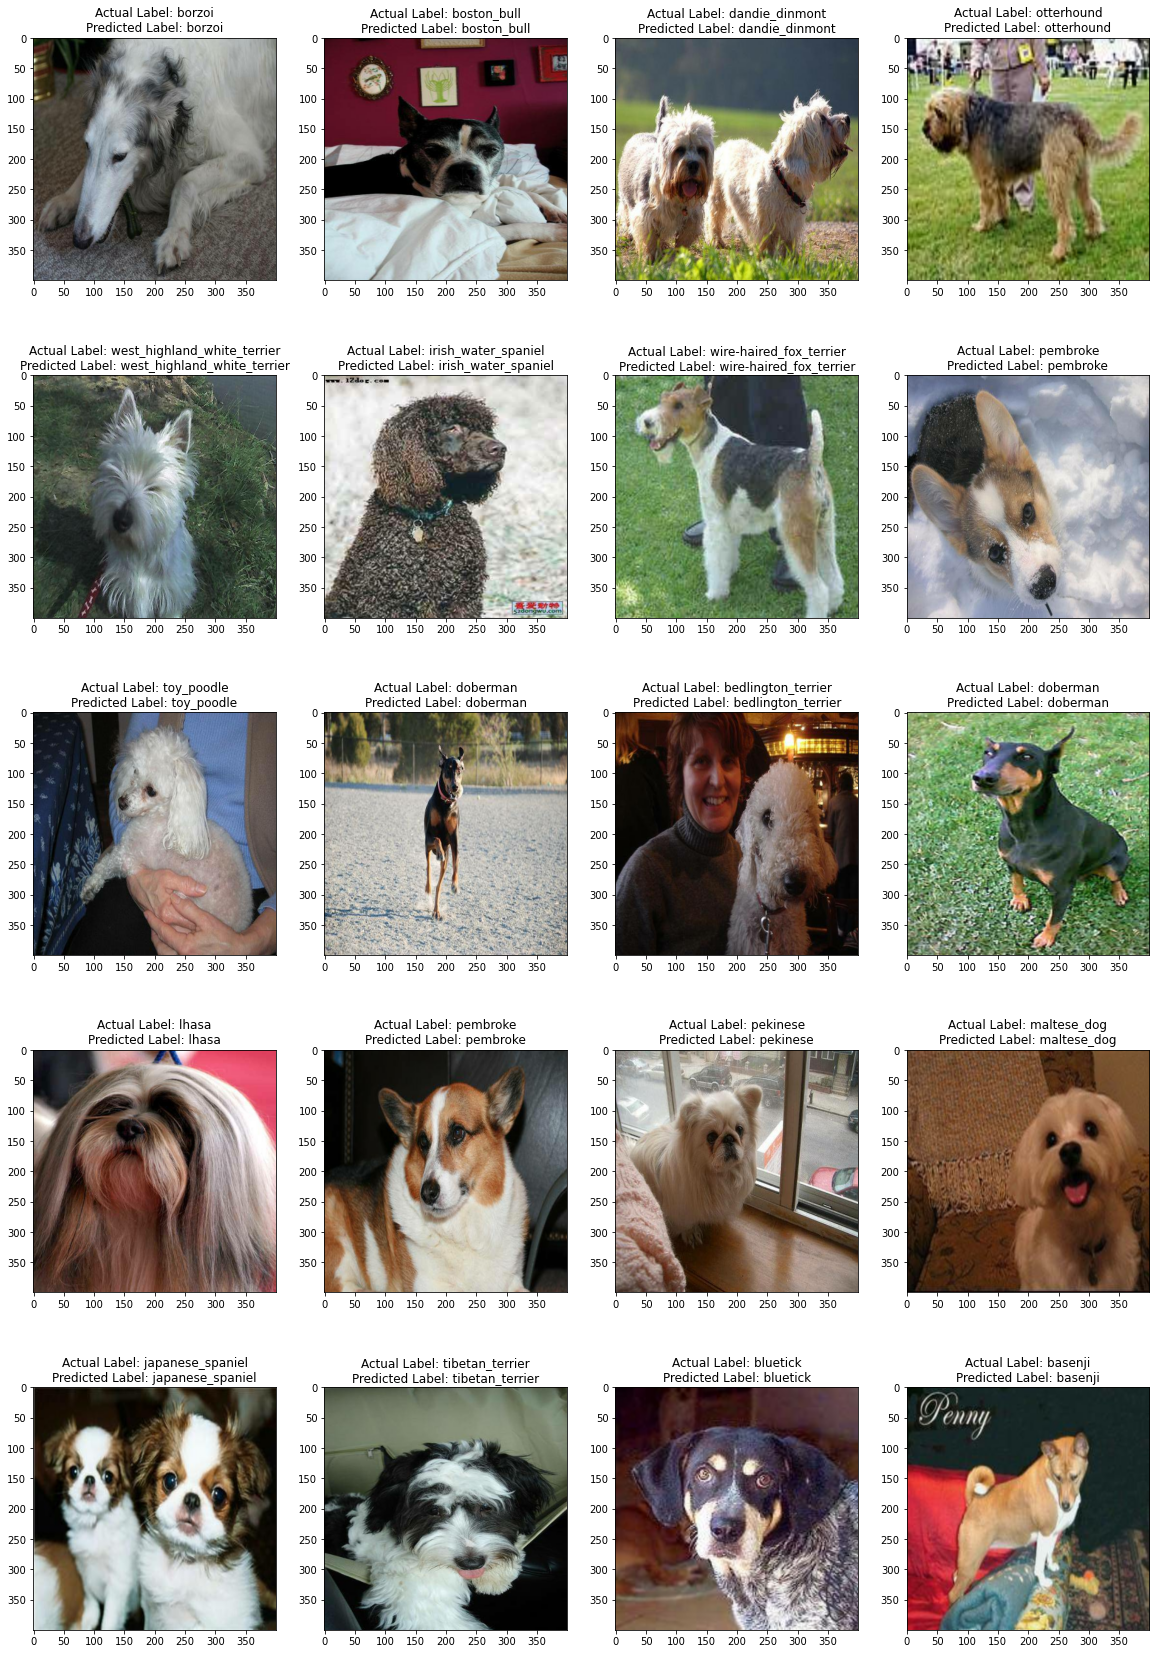

In [ ]:
plt.figure(figsize=(20,30))
for i in range(20):
  plt.subplot(5,4,i+1)
  image = tf.io.read_file(validation['path'].to_list()[i])
  image = tf.image.decode_jpeg(image, channels=3)
  image = image/255
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [400, 400])
  plt.imshow(image)
  actual_label = validation['label'].to_list()[i]
  predicted_label = list(le.classes_)[np.argmax(Stacked_model_1.predict(image[np.newaxis,:,:,:],verbose=0))]
  plt.title('Actual Label: '+ actual_label + '\n' + 'Predicted Label: ' + predicted_label)

plt.show()  

**PREDICTIONS ON TEST DATA:**

In [33]:
test_files_path = []
for root, dirs, files in os.walk("test", topdown=False):
   for name in sorted(files):
      test_files_path.append(os.path.join(root, name))

In [ ]:
columns_list = ['Id'] + list(le.classes_)

In [ ]:
submission = pd.DataFrame(columns=columns_list)

In [ ]:
for i in test_files_path:
  image = tf.io.read_file(i)
  image = tf.image.decode_jpeg(image, channels=3)
  image = image/255
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [400, 400])
  predictions = Stacked_model_1.predict(image[np.newaxis,:,:,:],verbose=0)
  submission.loc[len(submission)] = [i.split('.')[0].split('/')[-1]] +list(predictions[0])

In [ ]:
submission.head()

Id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   2.139819e-07  1.094294e-07   
1  00102ee9d8eb90812350685311fe5890   3.361014e-10  1.019968e-09   
2  0012a730dfa437f5f3613fb75efcd4ce   1.964741e-07  1.458350e-05   
3  001510bc8570bbeee98c8d80c8a95ec1   1.648509e-06  5.883683e-07   
4  001a5f3114548acdefa3d4da05474c2e   2.960967e-03  6.666225e-06   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         8.954563e-08  1.002571e-07                    3.719440e-07   
1         6.128227e-09  7.880616e-10                    5.106885e-09   
2         2.704518e-06  3.504686e-06                    2.694461e-07   
3         1.190299e-08  1.076520e-08                    1.619527e-07   
4         3.472306e-07  1.341161e-07                    4.204640e-06   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.680617e-08        2.825681e-08  3.742991e-08  1.007551e-07  ...   
1  9.120797e-09        2.045622e-08  1.970563e-09  4.599578e-08  ...   
2  2.097543e-06        9.825820e-07  1.528297e-07  4.120566e-07  ...   
3  5.936560e-06        1.734519e-09  3.019876e-08  1.564838e-07  ...   
4  1.091007e-06        3.490624e-07  5.187655e-07  1.355367e-06  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.064008e-07  4.014144e-07  1.620194e-08  9.643911e-08  1.018232e-06   
1  9.464552e-10  1.947865e-09  4.008616e-09  2.427782e-08  6.153609e-09   
2  2.657954e-07  1.141929e-07  1.603831e-06  1.375172e-06  1.315407e-06   
3  2.961026e-08  5.990249e-07  3.029888e-07  7.757379e-07  2.271561e-07   
4  4.081982e-06  9.589901e-06  1.463514e-06  3.782714e-07  2.725732e-06   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            7.009560e-08                 3.605624e-07  1.140118e-08   
1            8.157776e-09                 1.332999e-06  3.608584e-08   
2            1.093706e-04                 3.279826e-07  7.716348e-07   
3            4.661076e-08                 9.168078e-08  1.120036e-06   
4            3.023739e-07                 1.185645e-05  1.295535e-06   

   wire-haired_fox_terrier  yorkshire_terrier  
0             9.013888e-08       2.443559e-07  
1             2.399085e-08       5.922430e-09  
2             2.764236e-07       5.771936e-07  
3             2.505465e-09       2.226657e-07  
4             6.288167e-06       3.634568e-06  

[5 rows x 121 columns]

In [ ]:
submission.to_csv('/content/drive/MyDrive/dog_breed/final_submission.csv',index=False)

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/dog_breed/final_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Kaggle Submission Score:***

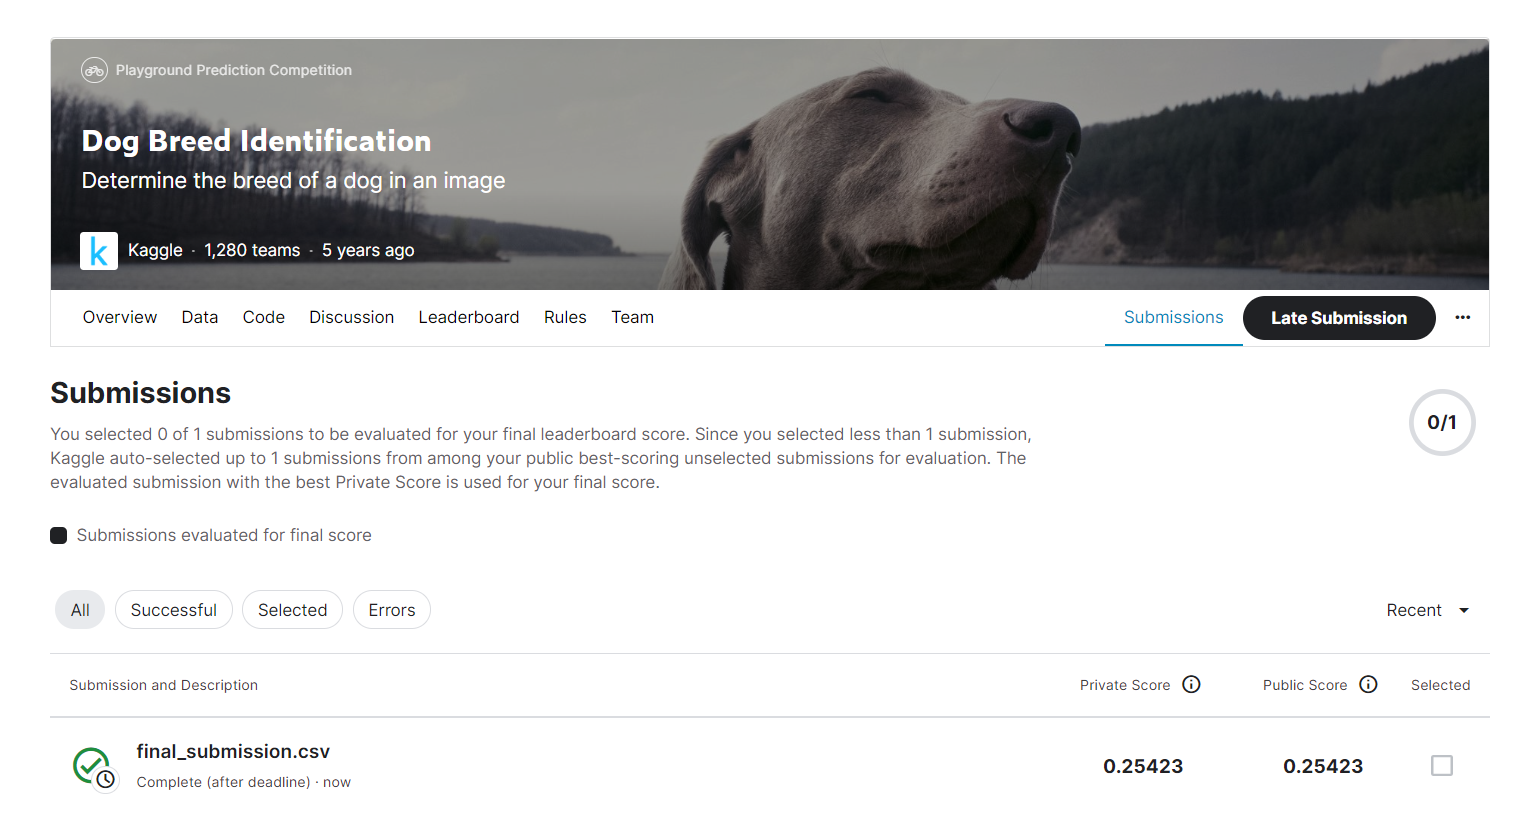